# Check location

In [1]:
print('Working directory: ')
!pwd 
print('\n.med file to use: ')
!ls *.med
print('\nparam_file.petsc :')
!cat param_file.petsc

Working directory: 
/Users/adriana/Documents/Meshes_for_DD/Smiley

.med file to use: 
smiley.med

param_file.petsc :
-my_order 1
-my_dummy_k -3
-my_dummy_range 5
-my_dummy_count 1000000
-my_dummy_noise 0.1

-pc_type lu
-pc_factor_mat_solver_package mumps
-ksp_type fgmres
-ksp_monitor
-ksp_converged_reason
-ksp_rtol 1e-8
-ksp_atol 1e-8



# Run begging analysis

In [2]:
!read_med -med_file *.med
!mofem_part -my_file out.h5m -output_file input_mesh.h5m -my_nparts 1 -dim 2 -adj_dim 1
!poisson_H -file_name input_mesh.h5m -my_order 6

[0] <inform> MoFEM version 0.10.0 (MOAB 5.1.0 Petsc Release Version 3.11.3, Jun, 26, 2019 )
[0] <inform> git commit id 064a7859c24c245cece2e22f4476c3c622f73af5
[0] <inform> Local time: 2020-11-12 17:19:38
[0] <inform> UTC time: 2020-11-12 17:19:38
[0] <inform> [MedInterface] Reading MED file V4.0.0 using MED library V4.0.0
[0] <inform> [MedInterface] Check mesh smiley nsteps 1
[0] <inform> [MedInterface] Reading mesh smiley nsteps 1
[0] <inform> [MedInterface] Read number of nodes 285
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name smiley
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name BOUNDARY_CONDITION             
[0] <inform> [read_med] meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name BOUNDARY_Q_BAR                 
[0] <inform> MoFEM version 0.10.0 (MOAB 5.1.0 Petsc Release Version 3.11.

# !! Check/select input values (change according to problem set up) !!

In [3]:
!mbconvert out_ori_result.h5m out_ori_result.vtk
!open out_ori_result.vtk

# in case a non integer is input
correct_int = 0

# Change according to the problem
max_p = 7.7
max_grad_p = 4.5
in_range = 5

correct = input('Variables chosen are: \n max_p = ' + str(max_p) + ';\n max_grad_p = ' + str(max_grad_p) + ';\n in_range = ' + str(in_range) + ';\n Is this correct? (1 = yes, 0 = no')

correct_int = int(correct)

Read "out_ori_result.h5m"
Wrote "out_ori_result.vtk"


In [4]:
if correct_int != 1: 
    print('\nPlease check the maximum absolute value of pressure (P_reference) from the reference FEM just performed. \nWhat is max pressure? (smiley: 7.5e-1)')
    in_max_p = input("Max absolute pressure? ")
    max_p = float(in_max_p)
    print('Max reference pressure is:', max_p)

    print('\nPlease check the maximum grad(p) in x and y directions from the reference FEM just performed. \nWhat is it? (smiley: 3.6)')
    in_max_grad_p=input("Max grad(p) in one direction? ")
    max_grad_p = float(in_max_grad_p)

    print('Max grad(p) in one direction is:', max_grad_p)
    print('\nPlease choose apropriate range (this will be used in creating a dummy data set):')

    in_range_guess=input('Choose an appropriate range for grad(p) in the dummy data set:')
    range_guess = float(in_range_guess)

    while range_guess < max_grad_p:
        print('Range chosen is', range_guess, ', this is smaller than max grad(p). \nPlease choose a new one:')
        in_range_guess=input()
        range_guess = float(in_range_guess)

    print('Range for analysis is', range_guess)

    in_range = range_guess 

# Run sample analysis

In [5]:
in_order = 1
in_k = -3
# in_range = 4
in_count = 10000
in_noise = 0

!rm sumanalys.csv

!poisson_dd_H -file_name analysis_mesh.h5m -my_order {in_order} -my_dummy_k {in_k} -my_dummy_range {in_range} -my_dummy_count {in_count} -my_dummy_noise {in_noise}

!mv ./sumanalys.csv ./sampleAna.csv

rm: sumanalys.csv: No such file or directory
[0] <inform> MoFEM version 0.10.0 (MOAB 5.1.0 Petsc Release Version 3.11.3, Jun, 26, 2019 )
[0] <inform> git commit id 064a7859c24c245cece2e22f4476c3c622f73af5
[0] <inform> Local time: 2020-11-12 17:19:49
[0] <inform> UTC time: 2020-11-12 17:19:49
[0] <inform> [DD] -my_order 1
[0] <inform> [DD] -my_dummy_k -3
[0] <inform> [DD] -my_dummy_range 5
[0] <inform> [DD] -my_dummy_count 10000
[0] <inform> [DD] -my_dummy_noise 0
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name smiley
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name BOUNDARY_CONDITION             
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name BOUNDARY_Q_BAR                 
The P_reference field is here :D
The L_reference field is here :D
[0] <inform> [FieldCore] Add field P field_id 4 space H1 approximati

# Load classes, definitions, etc.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
plt.style.use('ggplot')
%matplotlib inline
from numpy import genfromtxt
from numpy import mean
import math
from scipy.optimize import curve_fit

In [22]:
class MyData:
    def populate(self,name):
        self.name = name
        self.my_data = genfromtxt(name+'.csv', delimiter=',')
        self.order = self.my_data[:,0]
        self.gaussnum = self.my_data[:,1]
        self.datanum = self.my_data[:,2]
        self.dummy_noise = self.my_data[:,3]
        self.dummy_k = self.my_data[:,4]
        self.dummy_range = self.my_data[:,5]
        self.rmsErr = self.my_data[:,6]
        self.rmsPoiErr = self.my_data[:,7]
        self.Vol = self.my_data[:,8]
        self.iterations = self.my_data[:,9]
        self.rmsErrPerc = self.rmsErr/max_p*100
        self.meanPointDist = (((self.dummy_range*2)**2) / self.datanum)

In [23]:
class MyAnalysis:
    def __init__(self):
        self.varName = 'unidentified'
        d1 = MyData()
        d2 = MyData()
        d3 = MyData()
        d4 = MyData()
        d5 = MyData()
        d6 = MyData()
        d7 = MyData()
        d8 = MyData()
        d9 = MyData()
        self.variable = []
        self.csvNaming = []
        self.list = []
        self.data_list = [d1,d2,d3,d4,d5,d6,d7,d8,d9]

In [28]:
def box_ave(noiseAna, errorType, box = 0):
    ave_RMS = []
    for a in range(0,len(noiseAna.variable)):
        datanum = []
        nbp1 = []
        nbp2 = []
        nbp3 = []
        nbp4 = []
        nbp5 = []
        nbp6 = []
        nbp7 = []
        nbp8 = []
        nbp = [nbp1, nbp2, nbp3, nbp4, nbp5, nbp6, nbp7]

        for i in range(1,8):
            for j in range(0,len(noiseAna.data_list[a].datanum)):
                if noiseAna.data_list[a].datanum[j] == 10**i:
                    if errorType == 'rmsPoiErr':
                        nbp[i-1].append(noiseAna.data_list[a].rmsPoiErr[j])
                    if errorType == 'rmsErrPerc':
                        nbp[i-1].append(noiseAna.data_list[a].rmsErrPerc[j])
                    if errorType == 'rmsErr':
                        nbp[i-1].append(noiseAna.data_list[a].rmsErr[j])
                    if errorType == 'iterations':
                        nbp[i-1].append(noiseAna.data_list[a].iterations[j])
            datanum.append(10**i)
    
        ave_RMS.append([mean(nbp1), mean(nbp2), mean(nbp3), mean(nbp4), mean(nbp5), mean(nbp6), mean(nbp7)])

        if box == 1: # plotting box plots
            fig1, ax1 = plt.subplots(figsize=(6, 4))
            ax1.boxplot(nbp)
            ax1.set_xticklabels(datanum,
                                rotation=45, fontsize=8)
            plt.xlabel('# data points')
            plt.yscale('log')
            plt.title(noiseAna.varName + ' = ' + str(noiseAna.data_list[a].dummy_noise[0]))
            if errorType == 'rmsPoiErr':
                plt.ylabel('Point distance RMS error')
            if errorType == 'rmsErrPerc':
                plt.ylabel('Pressure RMS error [%]')
            if errorType == 'rmsErr':
                plt.ylabel('Pressure RMS error')
            if errorType == 'iterations':
                plt.ylabel('# iterations')
    # plotting averages
    plt.figure(figsize=(6, 4))
    for a in range(0,len(noiseAna.variable)):
        plt.plot(datanum, ave_RMS[a], label='noise = ' + str(noiseAna.data_list[a].dummy_noise[0]))
    plt.xlabel('# data points')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    if errorType == 'rmsPoiErr':
        plt.ylabel('Point distance RMS error')
    if errorType == 'rmsErrPerc':
        plt.ylabel('Pressure RMS error [%]')
    if errorType == 'rmsErr':
        plt.ylabel('Pressure RMS error')
    if errorType == 'iterations':
        plt.ylabel('# iterations')
        plt.yscale('linear')

# !! Analysis set up (this is the main part to change) !!

In [24]:
noiseAna = MyAnalysis()

# list analysis name with desired changin variable
noiseAna.varName = 'noise'
noiseAna.list.append(['noiseAna00', 0])
noiseAna.list.append(['noiseAna005', 0.05])
noiseAna.list.append(['noiseAna01', 0.1])

# populate the required fields
for i in range(0,len(noiseAna.list)):
    noiseAna.csvNaming.append(noiseAna.list[i][0])
    noiseAna.variable.append(float(noiseAna.list[i][1]))

#  just a check
print('variable name: ' + noiseAna.varName)
print('naming: ' + str(noiseAna.csvNaming))
print('variables: ' + str(noiseAna.variable))

variable name: noise
naming: ['noiseAna00', 'noiseAna005', 'noiseAna01']
variables: [0.0, 0.05, 0.1]


# !! Run Analysis (update to which variable is changing) !!

In [30]:
test = input("1 = run analysis; 0 = skip analysis")
test_int = int(test)
if test_int == 1:
    # comment changing variables
    in_order = 1
    in_k = -3
    # in_range = 4 # defined above
    # in_count = 10000
    # in_noise = 0
    
    !rm sumanalys.csv # making sure the previous analysis doesn't affect this one

    for a in range(2,len(noiseAna.variable)):
        in_noise = noiseAna.variable[a]
        csvName = noiseAna.csvNaming[a] + '.csv'
        for i in range(1,8): # 10^1 number of points in the data set
            for j in range(1,100): # how many realisations
                in_count = (10**i)
                !poisson_dd_H -file_name analysis_mesh.h5m -my_order {in_order} -my_dummy_k {in_k} -my_dummy_range {in_range} -my_dummy_count {in_count} -my_dummy_noise {in_noise} -skip_vtk 1
        !mv ./sumanalys.csv ./{csvName}

here :D
[0] <inform> [FieldCore] Add field P field_id 4 space H1 approximation base AINSWORTH_LEGENDRE_BASE rank 1 meshset 12682136550675316748
[0] <inform> [FieldCore] Add field Q field_id 8 space L2 approximation base AINSWORTH_LEGENDRE_BASE rank 2 meshset 12682136550675316749
[0] <inform> [FieldCore] Add field L field_id 16 space H1 approximation base AINSWORTH_LEGENDRE_BASE rank 1 meshset 12682136550675316750
[0] <inform> [FieldCore] Number of dofs 19242
[0] <inform> [FECore] Finite element dFE added. Nb. of elements added 476
[0] <inform> [FECore] Finite element bFE added. Nb. of elements added 98
[0] <inform> [FECore] Number of adjacencies 10976
[0] <inform> [ProblemsManager] SimpleProblem Nb. local dof 1522 by 1522 nb global dofs 1522 by 1522
[0] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 0 by 0 Nb. local dof 1522 by 1522
[0] <inform> [DD] [00:00:00.000006] Creating rtree with 10000000 points...
[0] <inform> [DD] [00:00:17.495034] rtree cre

# Postprocess Analysis

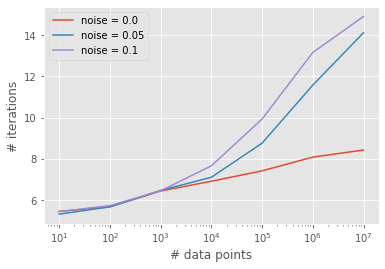

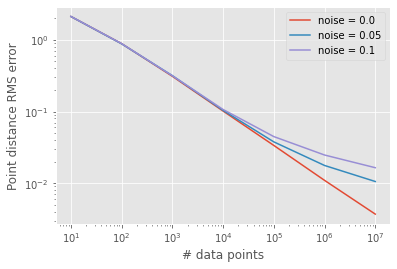

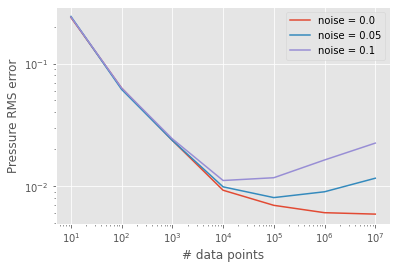

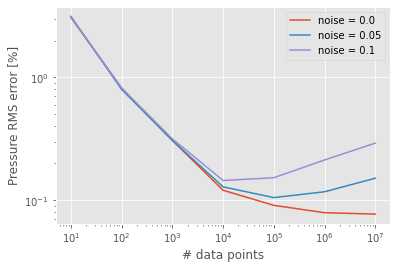

In [31]:
for a in range(0,len(noiseAna.variable)):
    noiseAna.data_list[a].populate(noiseAna.csvNaming[a])

box_ave(noiseAna, 'iterations', 0)
box_ave(noiseAna, 'rmsPoiErr')
box_ave(noiseAna, 'rmsErr')
box_ave(noiseAna, 'rmsErrPerc')